In [ ]:
# Reference: https://github.com/kaleko/CourseraML/tree/master/ex8

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import matplotlib
import scipy.optimize as opt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
ex8data1 = sio.loadmat('/content/drive/My Drive/AndrewNg-ML/ex8data1.mat')

In [4]:
X = ex8data1['X']
ycv = ex8data1['yval']
Xcv = ex8data1['Xval']

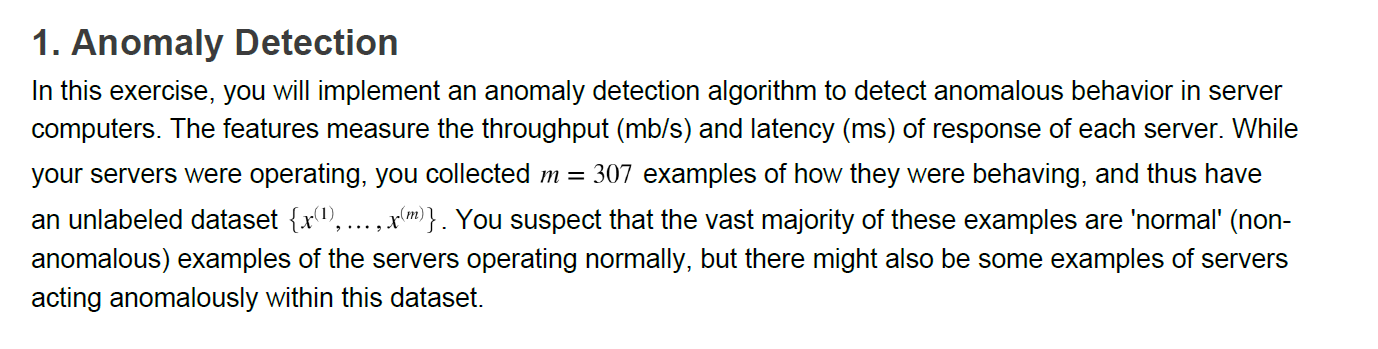

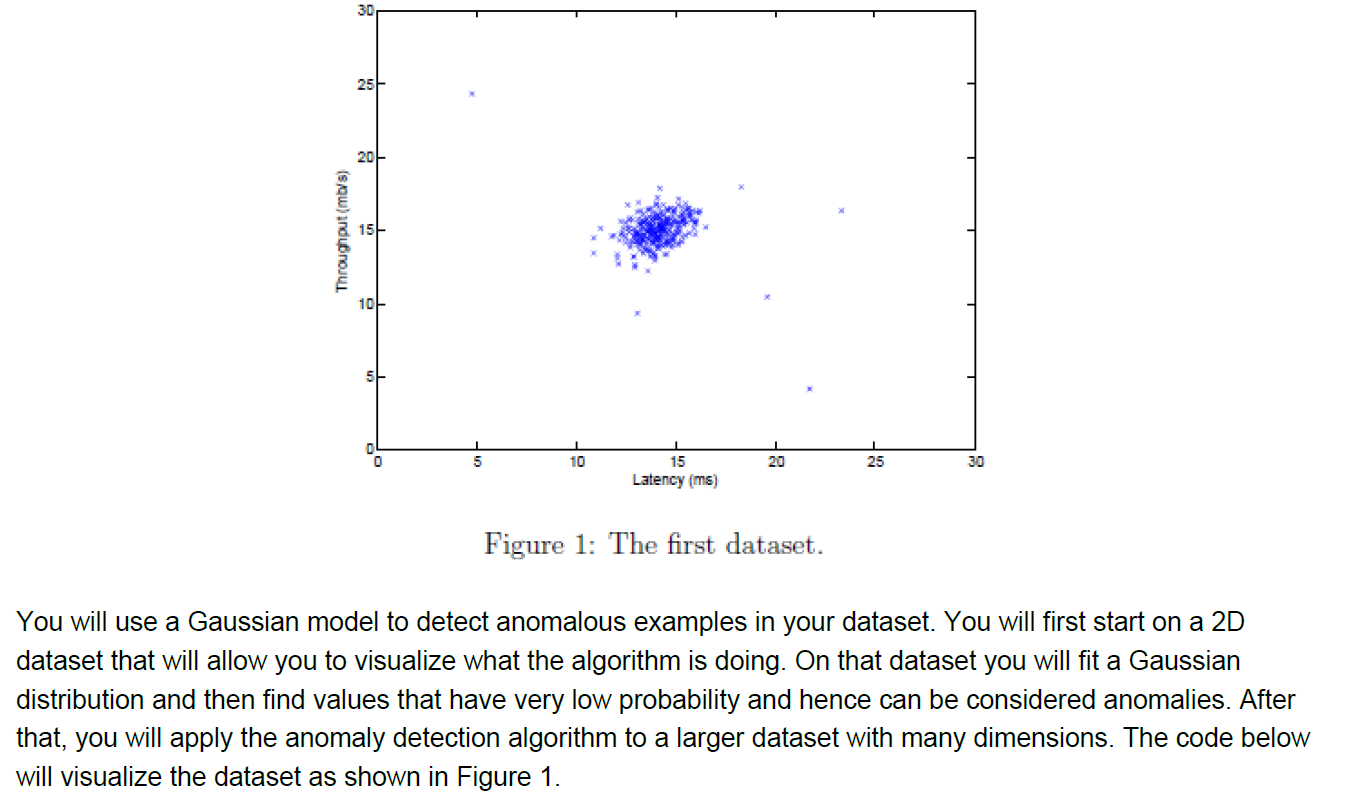

In [8]:
# Visualize the data
def plotData(X, newFig=False):
    if newFig:
        plt.figure(figsize=(8,6))
    plt.plot(X[:,0], X[:,1],'b+')
    plt.xlabel('Latency [ms]',fontsize=16)
    plt.ylabel('Throughput [mb/s]',fontsize=16)
    plt.grid(True)

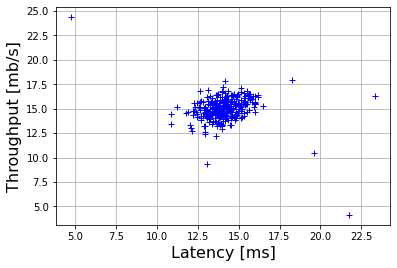

In [9]:
plotData(X)

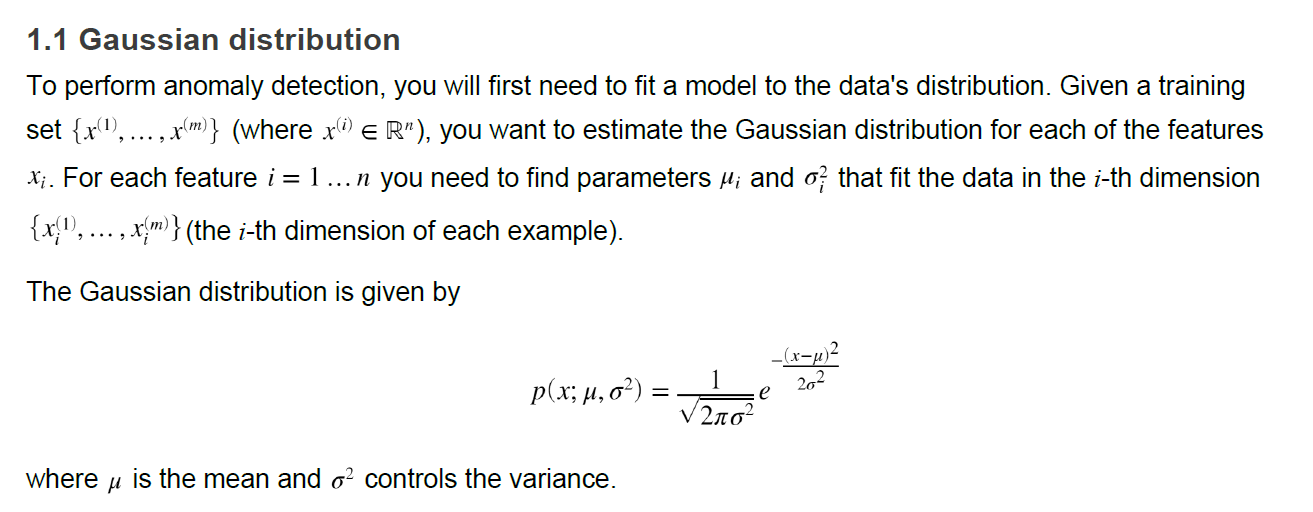

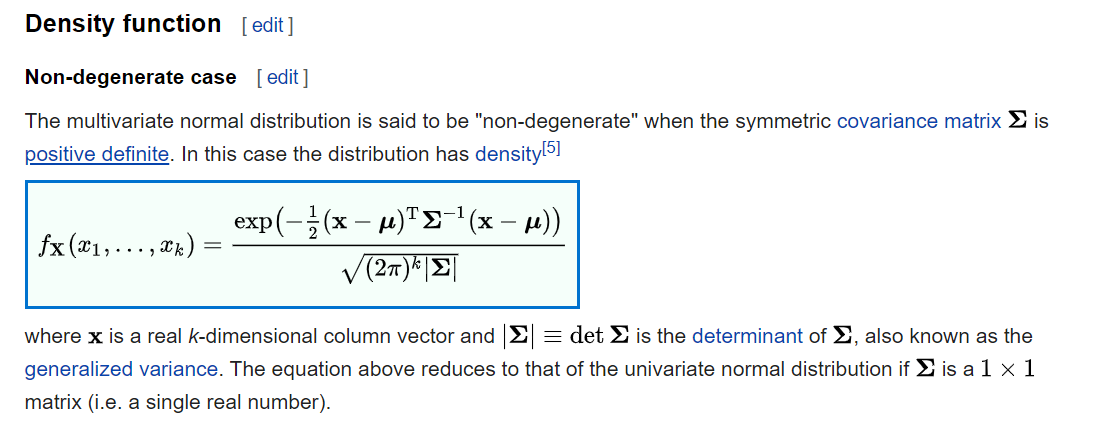
Reference: https://en.wikipedia.org/wiki/Multivariate_normal_distribution

In [10]:
# multivariate Gaussian
def gaussian_distribution(X, mu, sig2):   # sig2 = sigma^2
    """
    Function to compute the gaussian return values for a feature
    matrix, myX, given the already computed mu vector and sigma matrix.
    If sigma is a vector, it is turned into a diagonal matrix
    Uses a loop over rows; I didn't quite figure out a vectorized implementation.
    """
    m = X.shape[0]
    n = X.shape[1]
    if np.ndim(sig2) == 1:
        sig2 = np.diag(sig2)

    norm = 1./(np.power((2*np.pi), n/2) * np.sqrt(np.linalg.det(sig2)))
    inv = np.linalg.inv(sig2)
    exp = np.zeros((m,1))
    for irow in range(m):
        xrow = X[irow]
        exp[irow] = np.exp(-0.5*((xrow-mu).T).dot(inv).dot(xrow-mu))
    return norm*exp


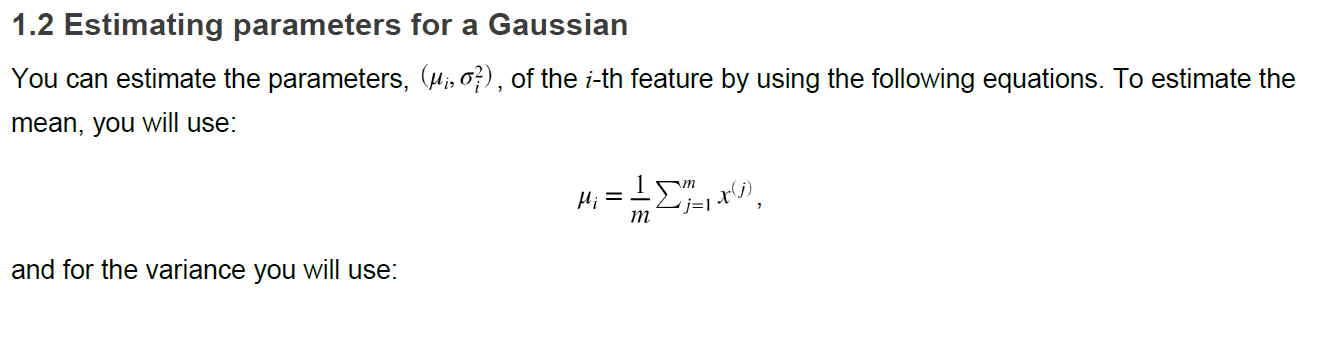

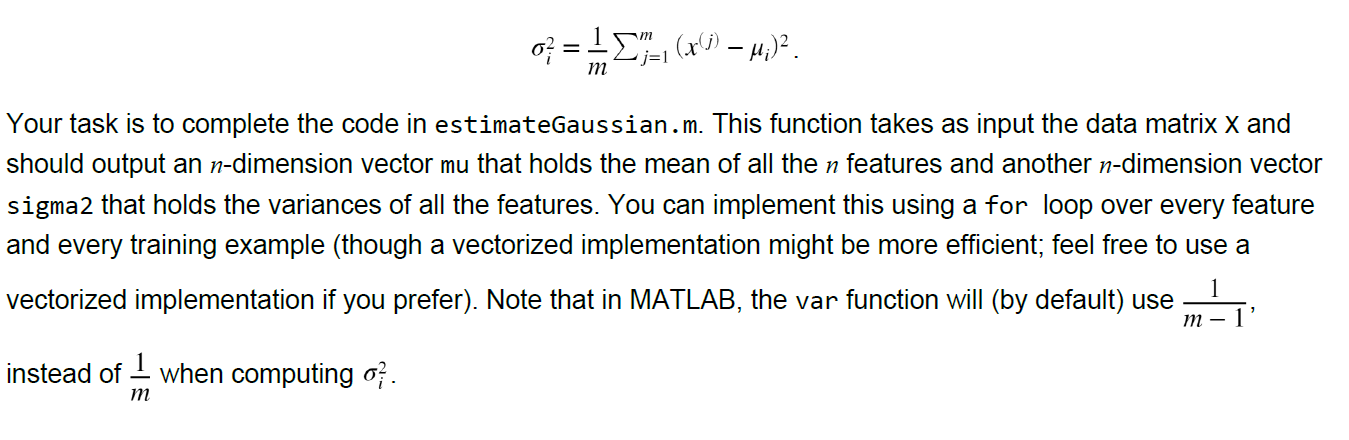

In [11]:
def getGaussianParams(X, useMultivariate = True):
    """
    Function that given a feature matrix X that is (m x n)
    returns a mean vector and a sigmasquared vector that are
    both (n x 1) in shape.
    This can do it either as a 1D gaussian for each feature,
    or as a multivariate gaussian.
    """
    m = X.shape[0]
    mu = np.mean(X, axis=0)  
    if not useMultivariate:
        sigma2 = np.sum(np.square(X-mu),axis=0)/float(m)
        return mu, sigma2
    else:
        sigma2 = ((X-mu).T.dot(X-mu))/float(m)
        return mu, sigma2

In [12]:
mu, sig2 = getGaussianParams(X, useMultivariate = True)

In [13]:
def plotContours(mu, sigma2, newFig=False, useMultivariate = True):
    delta = .5
    x = np.arange(0,30,delta)
    y = np.arange(0,30,delta)
    meshx, meshy = np.meshgrid(x, y)
    coord_list = [ entry.ravel() for entry in (meshx, meshy) ]
    points = np.vstack(coord_list).T
    z = gaussian_distribution(points, mu, sigma2)
    #if not useMultivariate:
    #    z = gausOrthog(points, mu, sigma2)
    #else: z = gausMV(points, mu, sigma2)
    z = z.reshape((x.shape[0],x.shape[0]))

    if newFig: plt.figure(figsize=(8,6))
    
    cont_levels = [10**exp for exp in range(-20,0,3)]
    contour = plt.contour(meshx, meshy, z, levels=cont_levels)

    plt.title('Gaussian Contours',fontsize=16)

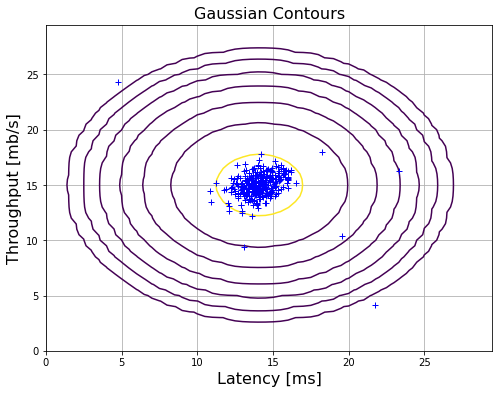

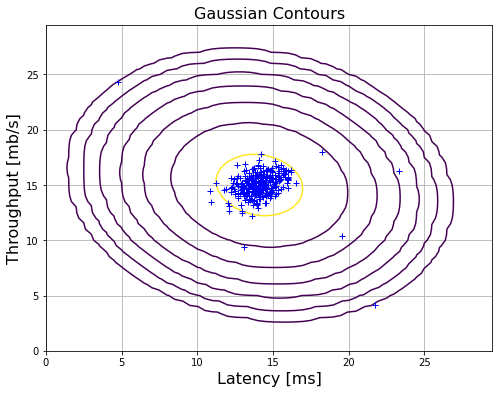

In [14]:
# First contours without using multivariate gaussian:
plotData(X, newFig=True)
useMV = False
plotContours(*getGaussianParams(X, useMV), newFig=False, useMultivariate = useMV)

# Then contours with multivariate gaussian:
plotData(X, newFig=True)
useMV = True
plotContours(*getGaussianParams(X, useMV), newFig=False, useMultivariate = useMV)

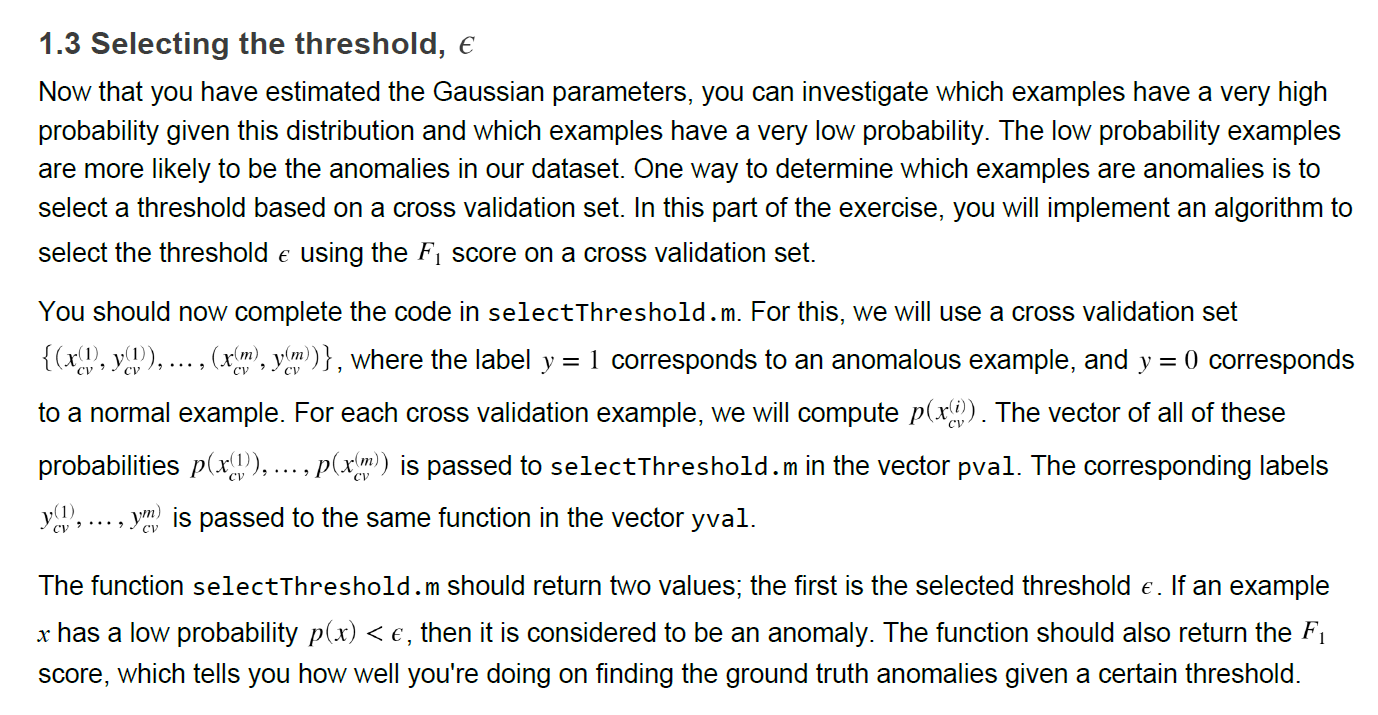

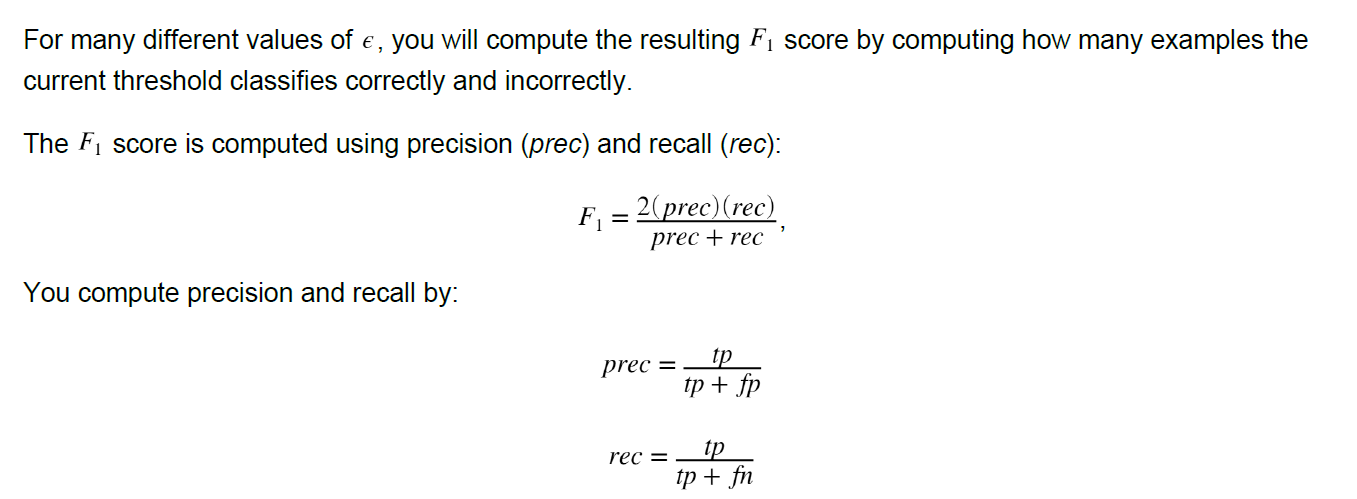

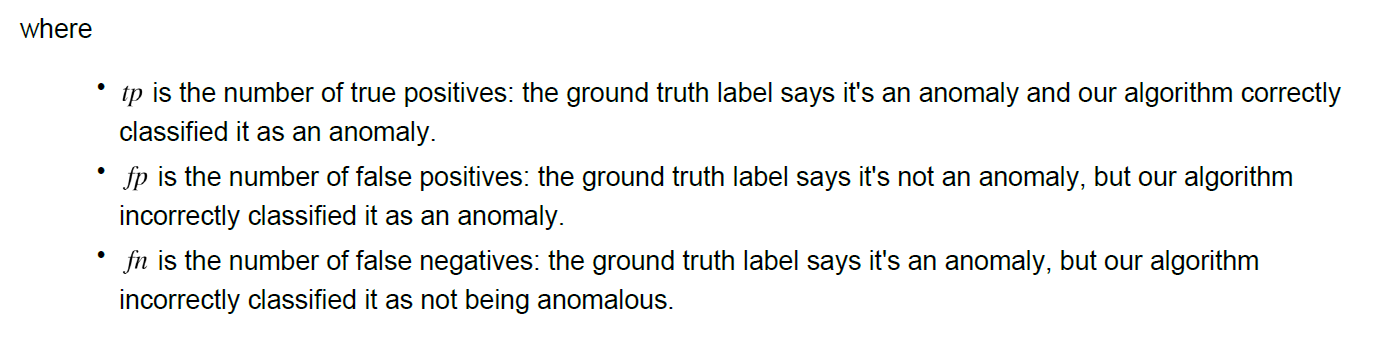

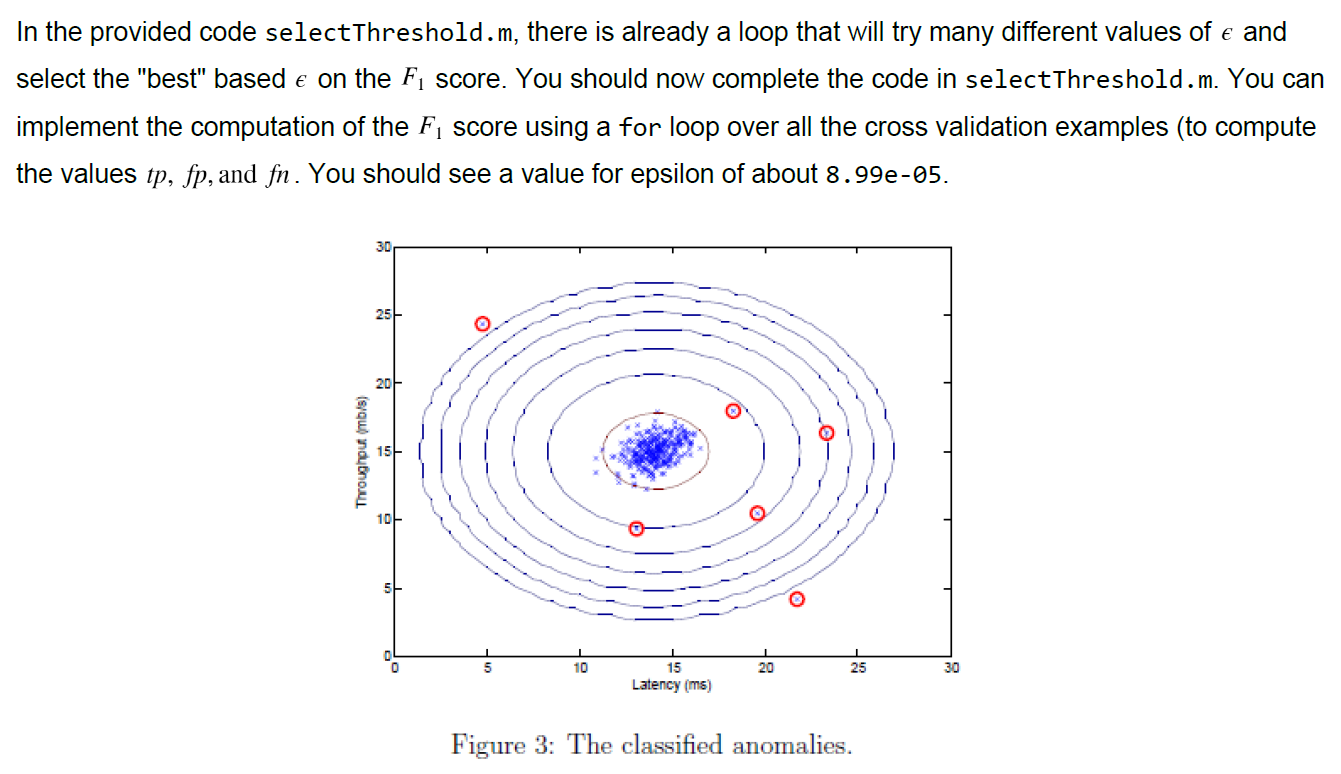

In [15]:
def computeF1(predVec, trueVec):
    """
    F1 = 2 * (P*R)/(P+R)
    where P is precision, R is recall
    Precision = "of all predicted y=1, what fraction had true y=1"
    Recall = "of all true y=1, what fraction predicted y=1?
    Note predictionVec and trueLabelVec should be boolean vectors.
    """
    #print predVec.shape
    #print trueVec.shape
    #assert predVec.shape == trueVec.shape
    
    P, R = 0., 0.
    if float(np.sum(predVec)):
        P = np.sum([int(trueVec[x]) for x in range(predVec.shape[0]) \
                    if predVec[x]]) / float(np.sum(predVec))
    if float(np.sum(trueVec)):
        R = np.sum([int(predVec[x]) for x in range(trueVec.shape[0]) \
                    if trueVec[x]]) / float(np.sum(trueVec))
        
    return 2*P*R/(P+R) if (P+R) else 0
    

In [22]:
def selectThreshold(ycv, pCVs):
    """
    Function to select the best epsilon value from the CV set
    by looping over possible epsilon values and computing the F1
    score for each.
    """
    # Make a list of possible epsilon values
    nsteps = 1000
    epses = np.linspace(np.min(pCVs),np.max(pCVs),nsteps)
    
    # Compute the F1 score for each epsilon value, and store the best 
    # F1 score (and corresponding best epsilon)
    bestF1, bestEps = 0, 0
    trueVec = (ycv == 1).flatten()
    for eps in epses:
        predVec = pCVs < eps
        thisF1 = computeF1(predVec, trueVec)
        if thisF1 > bestF1:
            bestF1 = thisF1
            bestEps = eps
            
    print ("Best F1 is , best eps is: ")
    print (bestF1,bestEps)
    return bestF1, bestEps

In [23]:
# Using the gaussian parameters from the full training set,
# figure out the p-value for each point in the CV set
pCVs = gaussian_distribution(Xcv, mu, sig2)

#You should see a value for epsilon of about 8.99e-05.
bestF1, bestEps = selectThreshold(ycv,pCVs)

Best F1 is , best eps is: 
0.8750000000000001 9.074844572965702e-05


In [24]:
def plotAnomalies(X, bestEps, newFig = False, useMultivariate = True):
    ps = gaussian_distribution(X, *getGaussianParams(X, useMultivariate))
    anoms = np.array([X[x] for x in range(X.shape[0]) if ps[x] < bestEps])
    if newFig: plt.figure(figsize=(8,6))
    plt.scatter(anoms[:,0],anoms[:,1], s=80, facecolors='none', edgecolors='r')

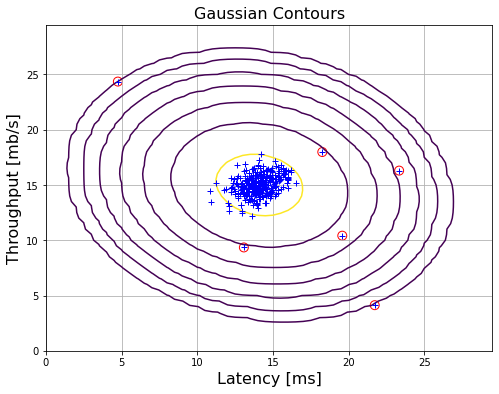

In [25]:
plotData(X, newFig=True)
plotContours(mu, sig2, newFig=False, useMultivariate=True)
plotAnomalies(X, bestEps, newFig=False, useMultivariate=True)

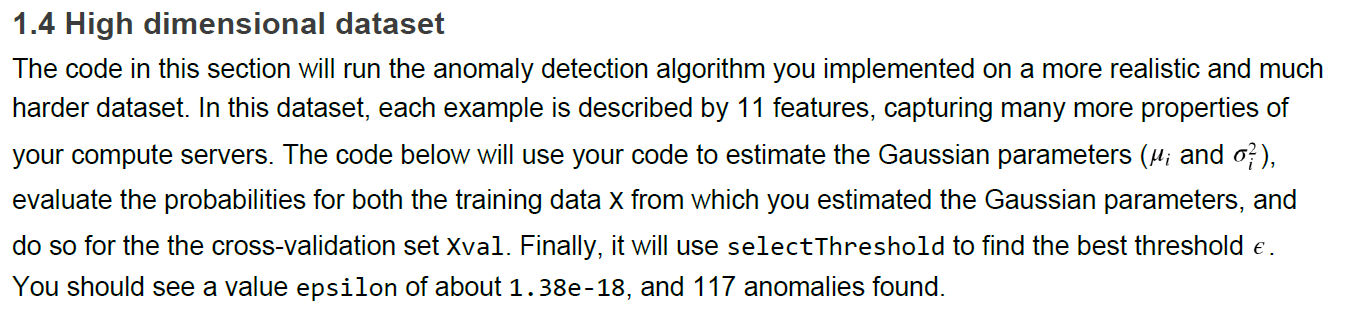

In [26]:
ex8data2 = sio.loadmat('/content/drive/My Drive/AndrewNg-ML/ex8data2.mat')

In [27]:
Xpart2 = ex8data2['X']
ycvpart2 = ex8data2['yval']
Xcvpart2 = ex8data2['Xval']

In [28]:
mu, sig2 = getGaussianParams(Xpart2, useMultivariate=False)
ps = gaussian_distribution(Xpart2, mu, sig2)
psCV = gaussian_distribution(Xcvpart2, mu, sig2)

# Using the gaussian parameters from the full training set,
# figure out the p-value for each point in the CV set
pCVs = gaussian_distribution(Xcvpart2, mu, sig2)

# You should see a value epsilon of about 1.38e-18, and 117 anomalies found.
bestF1, bestEps = selectThreshold(ycvpart2, pCVs)
anoms = [Xpart2[x] for x in range(Xpart2.shape[0]) if ps[x] < bestEps]
print ('# of anomalies found: ')
print (len(anoms))

Best F1 is , best eps is: 
0.6153846153846154 1.3786074982000245e-18
# of anomalies found: 
117
